<a href="https://colab.research.google.com/github/DARWICHAli/notebooks/blob/main/TAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet TAL

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import string
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk



import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
sns.set_theme(style="darkgrid")



## Parie 1

Vous avez à votre disposition sur Moodle un fichier CSV (df_wikinews_pr_tok_sample.csv)
d’articles publiés sur Wikinews étiquetés avec une catégorie. Le titre de l’article se trouve dans la
colonne ‘title’, son contenu dans la colonne ‘text’ et sa catégorie dans la colonne ‘categ’.

L’objectif est d’entraîner un outil de classification automatique des articles en fonction de leur
catégorie. La classification doit se baser sur le texte et le titre des articles. Le texte et le titre des articles
ont déjà été tokénisés et tous les tokens sont séparés par une espace.

L’apprentissage se fera à l’aide des méthodes vues lors des travaux pratiques
(2_TP_classification_documents et 3_TP_CNN). Vous êtes fortement encouragés à comparer différents
algorithmes de classification et différents types de traits déduits du texte des articles (par exemple,
utilisation de la désuffixation, application de différents seuils de fréquence pour les tokens à conserver
dans le vocabulaire, utilisation de différentes méthodes de pondération, etc. : à vous de trouver et de
tester des traits éventuellement pertinents). Les bonnes pratiques d’évaluation des modèles (validation
croisée notamment) devront être respectées. L’analyse des résultats comportera obligatoirement une
analyse qualitative (comment expliquer les problèmes observés ?) et pistes d’amélioration.

### Chargement des données

In [ ]:
# Lecture du fichier CSV

wiki_df = pd.read_csv("/content/drive/MyDrive/datasets/df_wikinews_pr_tok_sample.csv",
                      sep=",",
                      dtype={'title': 'object',
                            'text': 'object',
                            'categ': 'category'})
wiki_df = wiki_df.drop_duplicates().dropna(how = 'any')

In [ ]:
wiki_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   10000 non-null  object  
 1   text    10000 non-null  object  
 2   categ   10000 non-null  category
dtypes: category(1), object(2)
memory usage: 244.4+ KB


In [ ]:
wiki_df.categ.value_counts()

sports        4780
polit         2406
economie       987
justice        725
sci_cult       633
enviro_cat     469
Name: categ, dtype: int64

In [ ]:
wiki_df.head()

,title,text,categ
0,Tournoi des Quatre Nations 2017 : les résultat...,Rugby à XV Informations générales Internationa...,sports
1,"Pas de pardon pour Stanley Williams , le fonda...","13 décembre 2005 . – Stanley "" Tookie "" Willia...",justice
2,France : les époux Mégret sont condamnés pour ...,18 octobre 2006 . – Par un jugement rendu ce j...,polit
3,Championnat de France de basket - ball de Pro ...,17 octobre 2011 . – Cette deuxième journée est...,sports
4,Coupe d' Europe de rugby 2017 - 2018 : les rés...,Rugby à XV Informations générales Internationa...,sports


In [ ]:
X = wiki_df[['title', 'text']]
y = wiki_df.categ

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=12, shuffle=True)

In [ ]:
X_train.head()

,title,text
5951,Championnat d' Angleterre du Premiership de ru...,Rugby à XV Informations générales Internationa...
6630,Iditarod 2015 : décès de l' un des chiens de L...,Lance Mackey à la fin de l' Iditarod 2010 \n 1...
3240,Championnat de France 2014 - 2015 de Ligue 1 :...,Sommaire 1 Quelques chiffres \n 2 Résultats et...
5942,Gabon : violences postélectorales à Port - Gentil,Localisation du Gabon Port - Gentil \n 6 septe...
3789,"UVP : appel à une Constituante , c' est aux Va...",Fichier : Union - Valdotaine - Progressiste Lo...


In [ ]:
y_train.head()

5951    sports
6630    sports
3240    sports
5942     polit
3789     polit
Name: categ, dtype: category
Categories (6, object): ['economie', 'enviro_cat', 'justice', 'polit', 'sci_cult', 'sports']

In [ ]:
y_train.value_counts()

sports        3823
polit         1915
economie       788
justice        591
sci_cult       505
enviro_cat     378
Name: categ, dtype: int64

### Création de piplines

In [ ]:
# Fonction de tokénisation
def tokenize_variety(text):
    return text.split(' ')

# Objet CountVectorizer pour la transformation en sac de mots
var_vectorizer = CountVectorizer(tokenizer=tokenize_variety,
                                 min_df=0.01)

In [ ]:
res_var = var_vectorizer.fit_transform(X_test.title.head())
print("Input varieties")
print(X_test.title.head())
print()
print("Output bag of words")
var_bow = pd.DataFrame(res_var.toarray(), columns=var_vectorizer.get_feature_names())
var_bow.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)
var_bow

Input varieties
5669    La Chine a lancé avec succès la sonde Chang' e...
8800    Astronomie : l' existence d' une planète Proxi...
3205    Championnat de France 2010 - 2011 de Ligue 2 :...
8731    Ligue de hockey midget AAA : résultats du vend...
6412    Football : Grégory Coupet sera absent au minim...
Name: title, dtype: object

Output bag of words


,-,1,16,2,2010,2011,:,a,aaa,absent,...,proxima,résultats,sera,sonde,succès,trentième,trois,une,vendredi,vers
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0,0,1,1,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def split_into_tokens_nltk(desc) :
    return word_tokenize(desc)

# Liste des mots vides de NLTK + signes de ponctuation
nltk_stopwords = stopwords.words('french')+list(string.punctuation)

# Objet TfidfVectorizer
desc_vectorizer = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                                  lowercase=True,
                                  stop_words=nltk_stopwords,
                                  min_df=0.01)

In [ ]:
res_desc = desc_vectorizer.fit_transform(X_test.text.head())
print("Input text")
print(X_test.text.head())
print()
print("Output bag of words")
desc_bow = pd.DataFrame(res_desc.toarray(), columns=desc_vectorizer.get_feature_names())
desc_bow.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)
desc_bow

Input text
5669    La sonde Chang' e 1 modélisée . Source   : NAS...
8800    Orbite de Proxima Centauri c à l' intérieur du...
3205    Sommaire 1 Quelques chiffres \n 2 Résultats et...
8731    18 octobre 2009 . – Ce vendredi , 6 matchs de ...
6412    29 novembre 2009 . – Le gardien de but du Pari...
Name: text, dtype: object

Output bag of words


,-1,-17,-2,-20,-5,-6,-il,-t,//fr.wikinews.org/w/index.php,0,...,éditable,élites,équipe,étoile,évacué,évian,éviter,événement,éxito,–
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020974,0.000000,...,0.024797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044015,0.044015,0.104868
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057799,0.057799,0.027542,0.000000,...,0.000000,0.000000,0.000000,0.057799,0.000000,0.000000,0.000000,0.000000,0.000000,0.082625
2,0.014722,0.029445,0.073611,0.014722,0.014722,0.014722,0.000000,0.000000,0.007015,0.721392,...,0.008294,0.000000,0.000000,0.000000,0.000000,0.058889,0.000000,0.000000,0.000000,0.014031
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036980,0.000000,...,0.043722,0.077606,0.155212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073959
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036507,0.000000,...,0.043162,0.000000,0.000000,0.000000,0.076613,0.000000,0.076613,0.000000,0.000000,0.109520


In [ ]:
# Source : https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")}
            for text in descriptions]

text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)

In [ ]:
res_dict = text_stats_transformer.transform(X_test.text.head())
res_stats = text_stats_vectorizer.fit_transform(res_dict)
print("Input text")
print(X_test.text.head())
print()
print("Output statistics")
stats = pd.DataFrame(res_stats, columns=text_stats_vectorizer.get_feature_names())
stats.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)
stats

Input text
5669    La sonde Chang' e 1 modélisée . Source   : NAS...
8800    Orbite de Proxima Centauri c à l' intérieur du...
3205    Sommaire 1 Quelques chiffres \n 2 Résultats et...
8731    18 octobre 2009 . – Ce vendredi , 6 matchs de ...
6412    29 novembre 2009 . – Le gardien de but du Pari...
Name: text, dtype: object

Output statistics


,length,num_sentences
0,2628.0,33.0
1,1552.0,14.0
2,3287.0,35.0
3,1152.0,11.0
4,1273.0,20.0


In [ ]:
min_max_scaler = MinMaxScaler()
scaled_stats = min_max_scaler.fit_transform(res_stats)

In [ ]:
print("Before MinMax scaling")
print(res_stats)
print()
print("After MinMax scaling")
print(scaled_stats)

Before MinMax scaling
[[2628.   33.]
 [1552.   14.]
 [3287.   35.]
 [1152.   11.]
 [1273.   20.]]

After MinMax scaling
[[0.69133489 0.91666667]
 [0.18735363 0.125     ]
 [1.         1.        ]
 [0.         0.        ]
 [0.05667447 0.375     ]]


In [ ]:
column_trans = ColumnTransformer(
     [
         # Colonne 'variety' : bag-of-words
         ('title_bow', var_vectorizer, 'title'),
         # Colonne 'description' : tf-idf
         ('text_tfidf', desc_vectorizer, 'text'),
         # Colonne 'description' : statistiques
         (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
     ],
     # Colonnes 'expensive' et 'sparkling' : conservées telles quelles
     remainder='passthrough'
 )

In [ ]:
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('title_bow',
                                 CountVectorizer(min_df=0.01,
                                                 tokenizer=<function tokenize_variety at 0x7f93095ee200>),
                                 'title'),
                                ('text_tfidf',
                                 TfidfVectorizer(min_df=0.01,
                                                 stop_words=['au', 'aux',
                                                             'avec', 'ce',
                                                             'ces', 'dans',
                                                             'de', 'des', 'du',
                                                             'elle', 'en', 'et',
                                                             'eux', 'il', 'ils',
                                                             'je', 'la', 'le',
                                            

### Apprentissage

In [ ]:
# Prétraitement + apprentissage
classifier_pipeline = make_pipeline(
    # Préparation des données pour l'apprentissage
    column_trans,
    # Algorithme d'apprentissage
    LogisticRegression()
)

In [ ]:
classifier_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('title_bow',
                                                  CountVectorizer(min_df=0.01,
                                                                  tokenizer=<function tokenize_variety at 0x7f93095ee200>),
                                                  'title'),
                                                 ('text_tfidf',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  stop_words=['au',
                                                                              'aux',
                                                                              'avec',
                                                                              'ce',
                                                                              'ces',
         

In [ ]:
y_pred = classifier_pipeline.predict(X_test)
print("Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

Classification report:

              precision    recall  f1-score   support

    economie       0.74      0.65      0.70       199
  enviro_cat       0.82      0.60      0.70        91
     justice       0.80      0.66      0.73       134
       polit       0.77      0.90      0.83       491
    sci_cult       0.75      0.67      0.71       128
      sports       0.99      0.99      0.99       957

    accuracy                           0.87      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.87      0.87      0.87      2000



In [ ]:
# Liste des labels (classes) se trouvant dans les données de test
labels = np.unique(y_test)
# Matrice de confusion
cm =  confusion_matrix(y_test, y_pred, labels=labels)
# Matrice de confusion sous forme de DataFrame
confusion_df = pd.DataFrame(cm, index=labels, columns=labels)
print('confusion matrix\n')
print('(row=expected, col=predicted)')
confusion_df.head(n=15)

confusion matrix

(row=expected, col=predicted)


,economie,enviro_cat,justice,polit,sci_cult,sports
economie,130,5,2,48,11,3
enviro_cat,7,55,1,19,9,0
justice,4,1,89,38,1,1
polit,21,2,16,442,5,5
sci_cult,13,3,3,19,86,4
sports,0,1,0,10,2,944


Text(0.5, 0, 'predicted label')

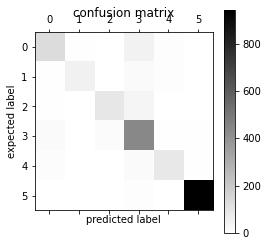

In [ ]:
plt.matshow(confusion_matrix(y_test, y_pred),
            cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

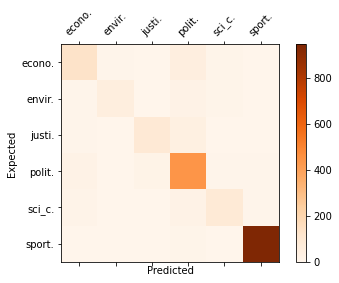

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
fig.colorbar(cax)
tick_marks = np.arange(len(labels))
labels_for_fig = [l[0:5]+'.' for l in labels]
plt.xticks(tick_marks, labels_for_fig, rotation=45)
plt.yticks(tick_marks, labels_for_fig)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### Apprentissage et évaluation par validation croisée

In [ ]:
# Nombre de plis
folds = 5
kfold = model_selection.KFold(n_splits=folds, shuffle=True, random_state=12)

In [ ]:
y_kfold_pred = model_selection.cross_val_predict(classifier_pipeline, X_train,
                                                   y_train, cv=kfold, n_jobs=-1)

In [ ]:
print(classification_report(y_train, y_kfold_pred))

              precision    recall  f1-score   support

    economie       0.69      0.62      0.65       788
  enviro_cat       0.77      0.57      0.65       378
     justice       0.75      0.59      0.66       591
       polit       0.74      0.89      0.81      1915
    sci_cult       0.70      0.56      0.62       505
      sports       0.99      0.98      0.99      3823

    accuracy                           0.85      8000
   macro avg       0.77      0.71      0.73      8000
weighted avg       0.85      0.85      0.85      8000



### StratifiedKFold

In [ ]:
stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, random_state=12)

In [ ]:
y_stratkfold_pred = model_selection.cross_val_predict(classifier_pipeline, X_train,
                                                   y_train, cv=stratkfold, n_jobs=-1)

In [ ]:
print(classification_report(y_train, y_stratkfold_pred))

              precision    recall  f1-score   support

    economie       0.68      0.63      0.65       788
  enviro_cat       0.76      0.59      0.67       378
     justice       0.75      0.60      0.66       591
       polit       0.74      0.89      0.81      1915
    sci_cult       0.74      0.59      0.65       505
      sports       0.99      0.99      0.99      3823

    accuracy                           0.86      8000
   macro avg       0.78      0.71      0.74      8000
weighted avg       0.86      0.86      0.85      8000



### Comparaison de plusieurs classifieurs

Baseline
              precision    recall  f1-score   support

    economie       0.00      0.00      0.00       788
  enviro_cat       0.00      0.00      0.00       378
     justice       0.00      0.00      0.00       591
       polit       0.00      0.00      0.00      1915
    sci_cult       0.00      0.00      0.00       505
      sports       0.48      1.00      0.65      3823

    accuracy                           0.48      8000
   macro avg       0.08      0.17      0.11      8000
weighted avg       0.23      0.48      0.31      8000

Mutinomial NB
              precision    recall  f1-score   support

    economie       0.73      0.43      0.54       788
  enviro_cat       0.73      0.44      0.55       378
     justice       0.72      0.51      0.59       591
       polit       0.59      0.94      0.72      1915
    sci_cult       0.56      0.39      0.46       505
      sports       1.00      0.91      0.95      3823

    accuracy                           0.78      8000


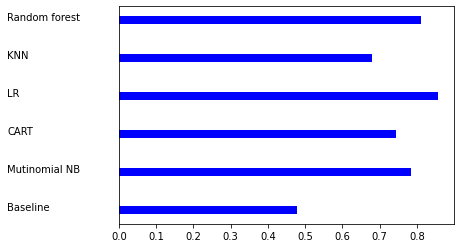

In [ ]:
# Modèles à comparer
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier())
]
# Evaluation de chaque résultat l'un après l'autre
scores = []
names = []
scoring = 'accuracy'
# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
for name, model in models:
    names.append(name)
    model_pipeline = make_pipeline(column_trans, model)
    y_pred = model_selection.cross_val_predict(model_pipeline,
                                               X_train, y_train,
                                               cv=kfold)
    print(name)
    print(classification_report(y_train, y_pred))
    acc = metrics.accuracy_score(y_train, y_pred)
    scores.append(acc)

# Représentation graphique des résultats
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

### Entraînement uniquement avec une partie des traits

In [ ]:
column_trans2 = ColumnTransformer(
     [
         # Colonne 'variety' : bag-of-words
         ('title_bow', var_vectorizer, 'title'),
         # Colonne 'description' : tf-idf
         ('text_tfidf', desc_vectorizer, 'text'),
     ],
     # Colonnes 'expensive' et 'sparkling' : conservées telles quelles
     #remainder='passthrough'
     remainder='drop'
 )
column_trans2

ColumnTransformer(transformers=[('title_bow',
                                 CountVectorizer(min_df=0.01,
                                                 tokenizer=<function tokenize_variety at 0x7f93095ee200>),
                                 'title'),
                                ('text_tfidf',
                                 TfidfVectorizer(min_df=0.01,
                                                 stop_words=['au', 'aux',
                                                             'avec', 'ce',
                                                             'ces', 'dans',
                                                             'de', 'des', 'du',
                                                             'elle', 'en', 'et',
                                                             'eux', 'il', 'ils',
                                                             'je', 'la', 'le',
                                                             'les', 'leur',
           

In [ ]:
# Validation croisée à 5 plis
for name, model in models:
    model_pipeline = make_pipeline(column_trans2, model)
    y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train,
                                               cv=kfold)
    print(name)
    print(classification_report(y_train, y_pred))

Baseline
              precision    recall  f1-score   support

    economie       0.00      0.00      0.00       788
  enviro_cat       0.00      0.00      0.00       378
     justice       0.00      0.00      0.00       591
       polit       0.00      0.00      0.00      1915
    sci_cult       0.00      0.00      0.00       505
      sports       0.48      1.00      0.65      3823

    accuracy                           0.48      8000
   macro avg       0.08      0.17      0.11      8000
weighted avg       0.23      0.48      0.31      8000

Mutinomial NB
              precision    recall  f1-score   support

    economie       0.73      0.43      0.54       788
  enviro_cat       0.72      0.44      0.55       378
     justice       0.72      0.51      0.59       591
       polit       0.59      0.94      0.72      1915
    sci_cult       0.56      0.39      0.46       505
      sports       1.00      0.91      0.95      3823

    accuracy                           0.78      8000


# CNN


## 1. Chargement des données

In [ ]:
# Liste des classes
class_names = sorted(wiki_df.categ.unique().categories.to_list())
print("Classes :", class_names)
print("Nombre d'exemplaires :", len(wiki_df))

Classes : ['economie', 'enviro_cat', 'justice', 'polit', 'sci_cult', 'sports']
Nombre d'exemplaires : 10000


In [ ]:
# On associe à chaque classe un identifiant unique
class_index = {class_names[i]:i for i in range(len(class_names))}
class_index

{'economie': 0,
 'enviro_cat': 1,
 'justice': 2,
 'polit': 3,
 'sci_cult': 4,
 'sports': 5}

In [ ]:
#X_train = wiki_df[['title', 'text']]
X_train = wiki_df.text
# Les noms des classes sont remplacées par leur identifiant (un entier positif)
y_train = wiki_df.categ.map(class_index)

## 2. Indexation du vocabulaire


In [ ]:
vectorizer = TextVectorization(max_tokens=8000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
print(len(voc))
voc[:5]

8000


['', '[UNK]', 'de', '\xa0', 'la']

In [ ]:
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
print(X_train.iloc[0])
output = vectorizer([X_train.iloc[0]])
for v in output.numpy()[0, :15]:
    print(v, vectorizer.get_vocabulary()[v])

Rugby à XV Informations générales International Championnat de Ligue celtique 2021 - 2022   : les résultats de la cinquième journée 
 Championnat d' Angleterre du Premiership de rugby 2021 - 2022   : les résultats de la sixième journée 
 Championnat de France de rugby 2021 - 2022   : les résultats de la huitième journée 
 Championnat de France de rugby Pro D2 2021 - 2022   : les résultats de la huitième journée 
 Championnat de Ligue celtique 2021 - 2022   : les résultats de la quatrième journée Top 14 Championnat de France de rugby 2021 - 2022   : les résultats de la huitième journée 
 Championnat de France de rugby 2021 - 2022   : les résultats de la septième journée 
 Championnat de France de rugby 2021 - 2022   : les résultats de la sixième journée 
 Championnat de France de rugby 2021 - 2022   : les résultats de la cinquième journée 
 Championnat de France de rugby 2021 - 2022   : les résultats de la quatrième journée Pro D2 Championnat de France de rugby Pro D2 2021 - 2022   : le

## 3. Chargement de plongements de mots pré-entraînés


In [ ]:
!wget -P data https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz

--2022-05-13 20:28:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287757366 (1.2G) [binary/octet-stream]
Saving to: ‘data/cc.fr.300.vec.gz’

cc.fr.300.vec.gz    100%[===================>]   1.20G  38.8MB/s    in 32s     

2022-05-13 20:28:59 (38.4 MB/s) - ‘data/cc.fr.300.vec.gz’ saved [1287757366/1287757366]



In [ ]:
!gzip -d /content/data/cc.fr.300.vec.gz

In [ ]:
embeddings_index = {}
with open('/content/data/cc.fr.300.vec', 'r', encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f'{len(embeddings_index)} vecteurs de mots ont été lus')

2000000 vecteurs de mots ont été lus


In [ ]:
num_tokens = len(voc)
embedding_dim = 300
hits = 0
misses = 0

# Préparation de la matrice
# Les mots qui ne se trouvent pas dans les plongements pré-entraînés seront
# représentés par des vecteurs dont toutes les composantes sont égales à 0,
# y compris la représentation utilisée pour compléter les documents courts et
# celle utilisée pour les mots inconnus [UNK]
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
print(f'{misses} sont absents')

7551 mots ont été trouvés dans les plongements pré-entraînés
449 sont absents


## 4. Construction et entraînement du modèle


In [ ]:
# Listes utilisées pour sauvegarder les résultats obtenus à chaque pli
acc_per_fold = []
loss_per_fold = []
histories = []
folds = 5
stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True,
                                             random_state=12)
fold_no = 1
for train, test in stratkfold.split(X_train, y_train):
  # Création du modèle
  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(num_tokens, embedding_dim, trainable=True,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  )
  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Conv1D(64, 5, activation="relu")(embedded_sequences)
  x = layers.MaxPooling1D(5)(x)
  x = layers.Conv1D(64, 5, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)

  x = layers.Dense(64, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  preds = layers.Dense(len(class_names), activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  model.summary()


  print('------------------------------------------------------------------------')
  print(f'Entraînement pour le pli {fold_no} ...')
  fold_x_train = vectorizer(X_train.iloc[train].to_numpy()).numpy()
  fold_x_val = vectorizer(X_train.iloc[test].to_numpy()).numpy()
  fold_y_train = y_train.iloc[train].to_numpy()
  fold_y_val = y_train.iloc[test].to_numpy()

  # Compilation du modèle : permet de préciser la fonction de perte et l'optimiseur
  # loss=sparse_categorical_crossentropy : entropie croisée, dans le cas où les
  #  classes cibles sont indiquées sous forme d'entiers. Il s'agira de minimiser
  #  la perte pendant l'apprentissage
  # optimizer=rmsprop : l'optimiseur détermine la manière doit les poids seront
  #  mis à jour pendant l'apprentissage
  model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
  )
  # Entraînement
  history = model.fit(fold_x_train, fold_y_train, batch_size=128, epochs=10,
            validation_data=(fold_x_val, fold_y_val))
  histories.append(history)
  # Evaluation sur les données de validation
  scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
  print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
        f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  fold_no = fold_no + 1

# Affichage des scores moyens par pli
print('---------------------------------------------------------------------')
print('Scores par pli')
for i in range(0, len(acc_per_fold)):
  print('---------------------------------------------------------------------')
  print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
        f'- Accuracy: {acc_per_fold[i]:.2f}%')
print('---------------------------------------------------------------------')
print('Scores moyens pour tous les plis :')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
      f'(+- {np.std(acc_per_fold):.2f})')
print(f'> Loss: {np.mean(loss_per_fold):.2f}')
print('---------------------------------------------------------------------')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         2400000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                              

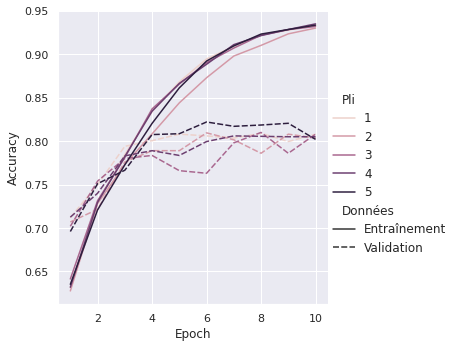

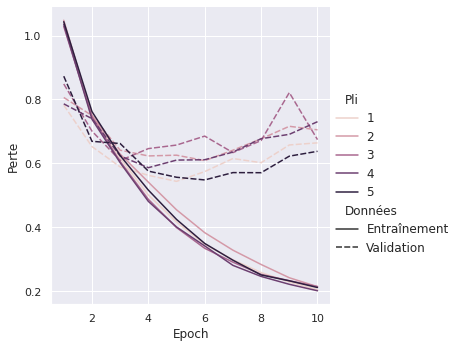

In [ ]:
accuracy_data = []
loss_data = []
for i, h in enumerate(histories):
  acc = h.history['acc']
  val_acc = h.history['val_acc']
  loss = h.history['loss']
  val_loss = h.history['val_loss']
  for j in range(len(acc)):
    accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
    accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
    loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
    loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

acc_df = pd.DataFrame(accuracy_data,
                      columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
            kind='line')

loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
            kind='line')